****Bike Network Data Collection****

This notebook is to be run at the start of the analysis process to access and download bicycle infrastucture from OpenStreetMap. This is completed using GeoPandas and the OSMNx packages. 

Any location with a boundary can be input from OpenStreetMap, such as a city, county, region or country (not recommended!). Filters of path/street type should be edited according to the usecase. Collected network features are displayed on a map at the end of this notebook.

In [18]:
# libary imports
import geopandas as gpd
import osmnx as ox
import folium
import os
import networkx as nx

# Configuring osmnx
useful_tags = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle']
ox.config(use_cache=True, log_console=True, useful_tags_way=useful_tags)

# get working directory
working_directory =  os.getcwd()

c:\Users\b8008458\Anaconda3\envs\clean_ox\Lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [30]:
# input location
place = "District Zurich, Switzerland"

# show map
map = False # use True or False 

# run analysis scripts
run_scripts = False # True or False

# use fast mode to skip slow centraility measures being computed
fast_mode = True # True or False

# use elevation mode == True to get grades and heights
elevation_mode = False

# Here are some nice small cities to try

# City of Chester, United Kingdom
# Roosendaal, Netherlands
# Columbus, Nebraska, USA


# store choosen place for future scripts
%store place
%store fast_mode
%store elevation_mode

Stored 'place' (str)
Stored 'fast_mode' (bool)
Stored 'elevation_mode' (bool)


In [20]:
# get networks and boundary

road_network = ox.graph_from_place(place, network_type= 'drive', simplify=True)

bikeable_network = ox.graph_from_place(place, network_type= 'all', simplify=True) # we use the 'all' tag to ensure paths where walking and cycling allowed are accessed

boundary = ox.geocode_to_gdf(place)


In [21]:
# add evelvations from Open Topo Data
if elevation_mode == True:
    road_network = ox.add_node_elevations_google(road_network, 
                                                api_key=place, # api key is not needed for opentopodata
                                                max_locations_per_batch=100,
                                                pause_duration=1,
                                                precision=3,
                                                url_template="https://api.opentopodata.org/v1/aster30m?locations={}&key={}")

    road_network = ox.elevation.add_edge_grades(road_network)

    bikeable_network = ox.add_node_elevations_google(bikeable_network, 
                                                api_key=place, # api key is not needed for opentopodata
                                                max_locations_per_batch=100,
                                                pause_duration=1,
                                                precision=3,
                                                url_template="https://api.opentopodata.org/v1/aster30m?locations={}&key={}")

    bikeable_network = ox.elevation.add_edge_grades(bikeable_network)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [24]:
# split into nodes and edges
bike_network_edges = ox.utils_graph.graph_to_gdfs(bikeable_network, nodes=False, edges=True)
bike_network_nodes = ox.utils_graph.graph_to_gdfs(bikeable_network, nodes=True, edges=False)

In [25]:
# keep on the street edge types that show 'proper' bike infrastructure

if 'cycleway' in bike_network_edges.columns:
    bike_network_edges = bike_network_edges[(bike_network_edges.highway == 'cycleway') 
                | (bike_network_edges.highway == 'bridleway') # this tag may need removing
                | (bike_network_edges.cycleway == 'crossing')
                | (bike_network_edges.cycleway == 'track')
                | (bike_network_edges.cycleway == 'separate')
                | (bike_network_edges.cycleway == 'oppesite_track') # this tag may need removing
                | ((bike_network_edges.bicycle == 'yes') & (bike_network_edges.highway== 'footway')) # this tag may need removing
                | (bike_network_edges.bicycle == 'designated') # this tag may need removing 
                | (bike_network_edges.bicycle == 'permissive') # this tag may need removing
                | (bike_network_edges.bicycle == 'use_sidepath')
                | (bike_network_edges.motor_vehicle == 'no') & (bike_network_edges.highway== 'residential')
                | (bike_network_edges.motor_vehicle == 'no') & (bike_network_edges.highway== 'unclassifed')
                ]

# Places in the USA often lack the 'cycleway' and 'bicycle' tags

else:
    bike_network_edges = bike_network_edges[(bike_network_edges.highway == 'cycleway') 
                | (bike_network_edges.highway == 'bridleway') # this tag may need removing
                ]


In [26]:
# join nodes and edges back into a network

bike_network =  ox.utils_graph.graph_from_gdfs(bike_network_nodes, bike_network_edges) 

# remove isolated node

bike_network = ox.utils_graph.remove_isolated_nodes(bike_network)

In [27]:
# set up map
m = ox.folium.plot_graph_folium(road_network, popup_attribute = 'highway' , zoom = 1, fit_bounds= True, weight = 0.5, opacity = 0.5)
folium.features.Choropleth(boundary, fill_color = '#03E7FF', fill_opacity = 0.04, line_color='#50DBEA', line_opacity=0.6 ).add_to(m)
m = ox.folium.plot_graph_folium(bike_network, graph_map = m, popup_attribute = 'highway' , zoom = 1, fit_bounds= True,color = 'red', weight= 1)

def show_map(map):
    if map == True:
        print("Plotting...")
        return m

# plot map
show_map(map)

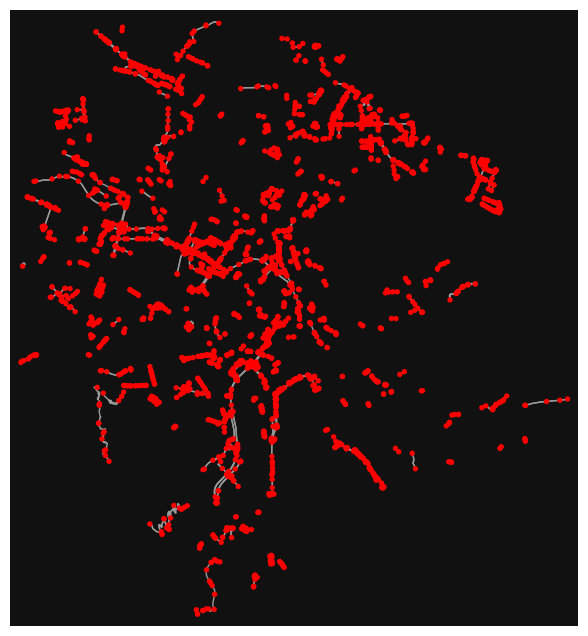

In [28]:
# plot bike network with nodes 

fig, ax = ox.plot_graph(bike_network, node_color="r")

In [29]:
# save networks and boundary for future analysis

ox.io.save_graphml(bike_network, filepath=working_directory + "\Data\\bike_network.xml") 

ox.io.save_graphml(road_network, filepath=working_directory + "\Data\\road_network.xml") 

boundary.to_file(working_directory + '\Data\\boundary.gpkg')

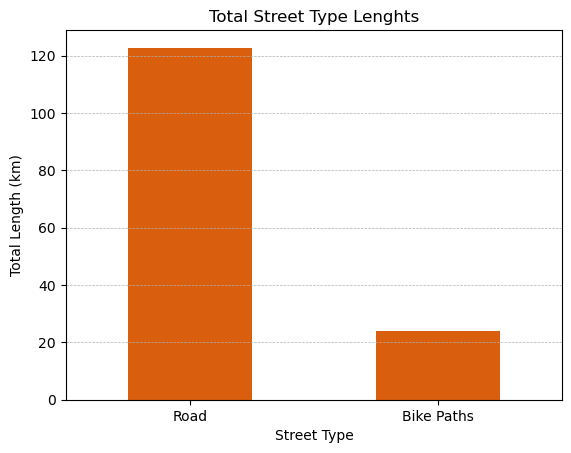

The ratio of road network ( 122.7930125 km) to bike network ( 24.0687155 km) is 1 : 5.101768413856568.
16.993013191750926
Bike network entropy is:  3.550044003090474


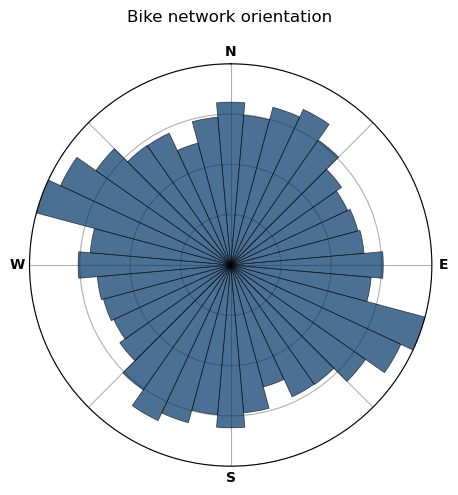

Road network entropy is:  3.5573372684643862


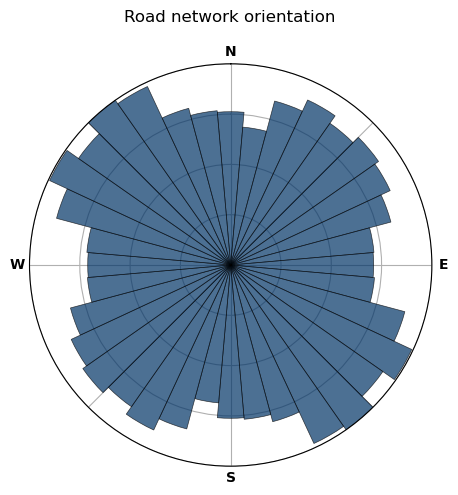

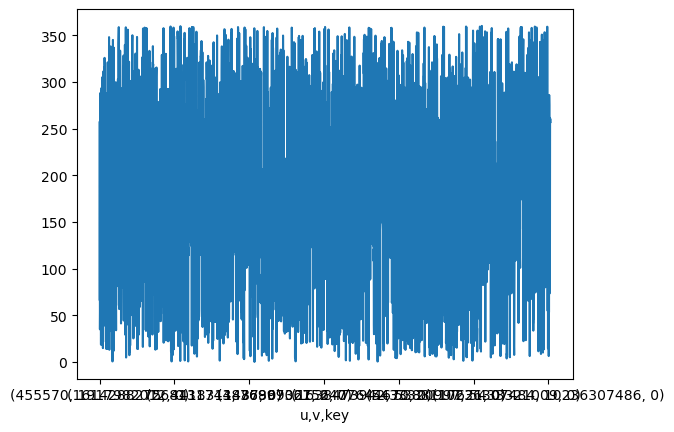

c:\Users\b8008458\Anaconda3\envs\geoenvCOPY\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length
c:\Users\b8008458\Anaconda3\envs\geoenvCOPY\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length


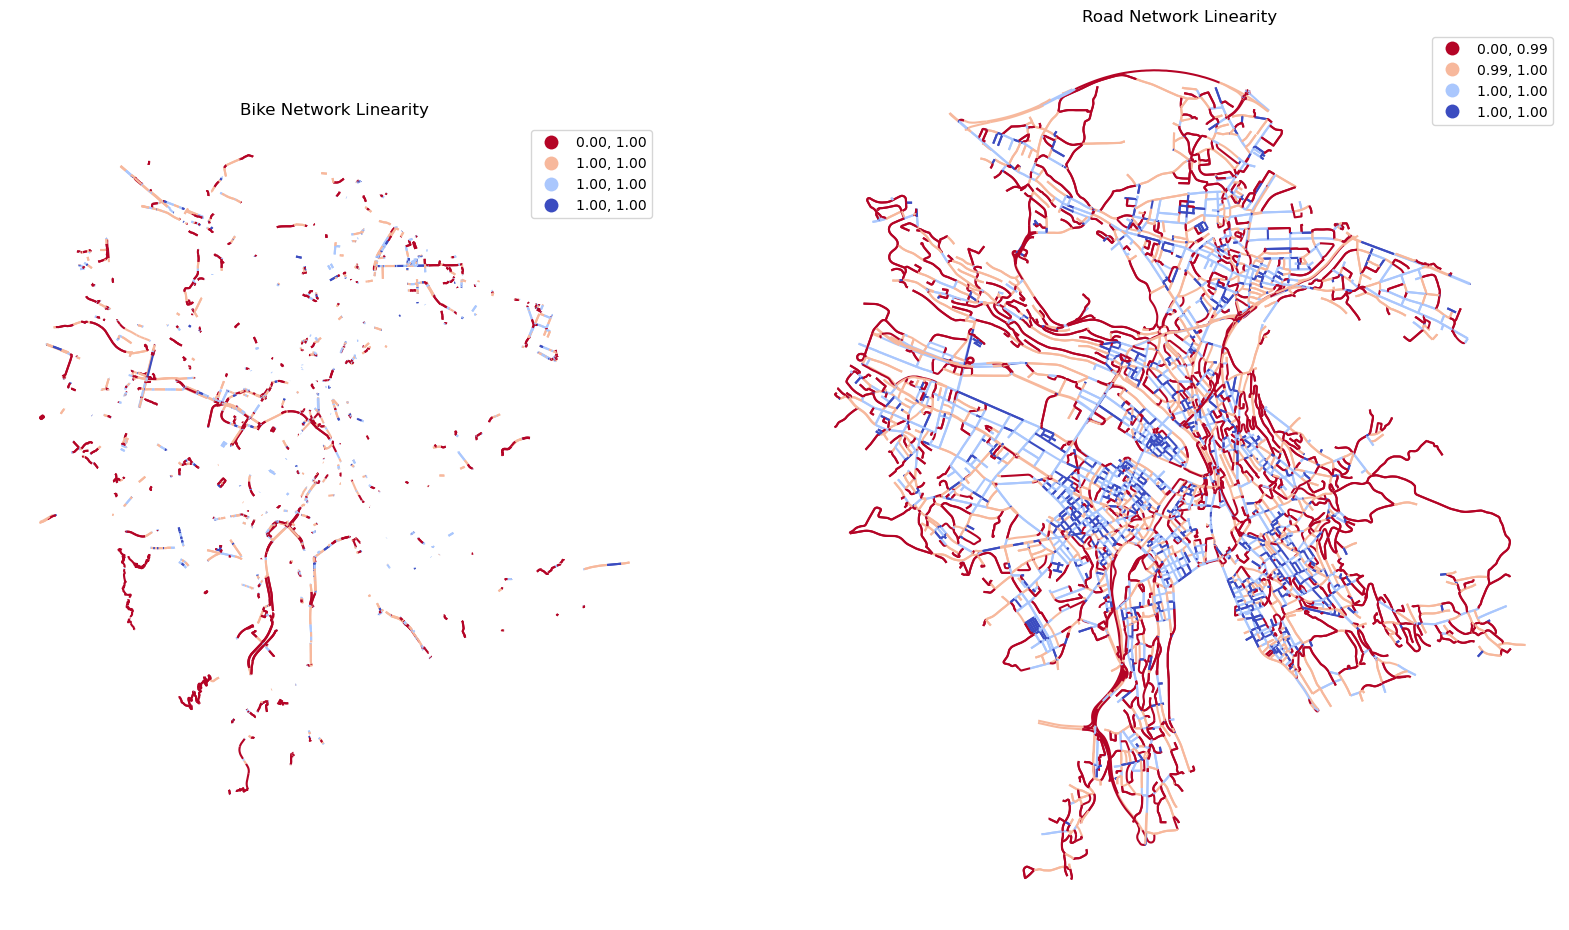

c:\Users\b8008458\Anaconda3\envs\geoenvCOPY\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
c:\Users\b8008458\Anaconda3\envs\geoenvCOPY\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
C:\Users\b8008458\AppData\Local\Temp\ipykernel_19112\1927408740.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(new_rows, ignore_index=True) # append new rows
C:\Users\b8008458\AppData\Local\Temp\ipykernel_19112\4237037577.py:13: FutureWarning: The 

Script 02 finished


C:\Users\b8008458\AppData\Local\Temp\ipykernel_19112\4237037577.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  metrics['place'] = metrics['place'].str.replace('.csv','') # remove spare data


In [ ]:
# run next notebook
if run_scripts == True:
    %run ./01-bike-network-metric-generation.ipynb
    %run ./02-bike-network-data-wrangling.ipynb